In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append(os.path.abspath("../.."))
from configs import GOOGLE_APPLICATION_CREDENTIALS,GCS_BUCKET_NAME,GCS_PROJECT_ID
from google.cloud import bigquery
from src.utils.io_utils import upload_to_bigquery
from clean_utils import *

In [2]:
client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS)
table_id = f"{GCS_PROJECT_ID}.{GCS_BUCKET_NAME}.data_cleaned"

In [3]:
query = """SELECT *
FROM `khangtestdbt.xecupredict.chotot_com` """
data_chotot = client.query(query).to_dataframe()
data_chotot.head(1)

,name,price,Số_Km_đã_đi,Xuất_xứ,Tình_trạng,Chính_sách_bảo_hành,Hãng,Dòng_xe,Năm_sản_xuất,Hộp_số,Nhiên_liệu,Kiểu_dáng,Số_chỗ,Trọng_lượng,Trọng_tải,Số_đời_chủ,Có_phụ_kiện_đi_kèm,Còn_hạn_đăng_kiểm
0,Alphard nhập khẩu NHẬT 2025 - xe giao sớm,4.510.000.000 đ,None,Nhật Bản,Mới,Bảo hành hãng,Toyota,Alphard,2025,Tự động,Động cơ Hybrid,Minivan (MPV),7,None,None,None,None,None


In [4]:
df_chotot = data_chotot.copy()

In [5]:
df_chotot.columns

Index(['name', 'price', 'Số_Km_đã_đi', 'Xuất_xứ', 'Tình_trạng',
       'Chính_sách_bảo_hành', 'Hãng', 'Dòng_xe', 'Năm_sản_xuất', 'Hộp_số',
       'Nhiên_liệu', 'Kiểu_dáng', 'Số_chỗ', 'Trọng_lượng', 'Trọng_tải',
       'Số_đời_chủ', 'Có_phụ_kiện_đi_kèm', 'Còn_hạn_đăng_kiểm'],
      dtype='object')

In [6]:
df_chotot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 2632 non-null   object
 1   price                2632 non-null   object
 2   Số_Km_đã_đi          2361 non-null   object
 3   Xuất_xứ              2632 non-null   object
 4   Tình_trạng           2632 non-null   object
 5   Chính_sách_bảo_hành  2632 non-null   object
 6   Hãng                 2632 non-null   object
 7   Dòng_xe              2632 non-null   object
 8   Năm_sản_xuất         2632 non-null   object
 9   Hộp_số               2632 non-null   object
 10  Nhiên_liệu           2632 non-null   object
 11  Kiểu_dáng            2342 non-null   object
 12  Số_chỗ               2435 non-null   object
 13  Trọng_lượng          2361 non-null   object
 14  Trọng_tải            2361 non-null   object
 15  Số_đời_chủ           1114 non-null   object
 16  Có_phụ

In [7]:
df_chotot = df_chotot[["Số_Km_đã_đi", "Xuất_xứ", "Kiểu_dáng", "Nhiên_liệu", "name", "price", "Hãng", "Năm_sản_xuất"]].copy()

In [8]:
df_chotot.columns = ["km", "origin", "body", "fuel", "name", "price", "brand", "age"]

In [9]:
df_chotot.describe(include='all').T

,count,unique,top,freq
km,2361,523,100000,78
origin,2632,11,Việt Nam,1149
body,2342,9,SUV / Cross over,894
fuel,2632,4,Xăng,1988
name,2632,2610,VinFast VF5 Plus 2025,3
price,2632,730,295.000.000 đ,26
brand,2632,46,Toyota,561
age,2632,34,2025,313


1.name

In [10]:
df_chotot["name"] = df_chotot["name"].apply(clean_name)
df_chotot.head(1)

,km,origin,body,fuel,name,price,brand,age
0,None,Nhật Bản,Minivan (MPV),Động cơ Hybrid,Alphard nhập khẩu NHẬT 2025 xe giao sớm,4.510.000.000 đ,Toyota,2025


2.price

In [11]:
df_chotot["price"].head(5)

0    4.510.000.000 đ
1    1.299.000.000 đ
2    1.010.000.000 đ
3      675.000.000 đ
4      980.000.000 đ
Name: price, dtype: object

In [12]:
df_chotot["price"] = (
    df_chotot["price"]
    .str.replace("đ", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.strip()
    .astype(float)
    .astype("Int64")
)
df_chotot.price.head()

0    4510000000
1    1299000000
2    1010000000
3     675000000
4     980000000
Name: price, dtype: Int64

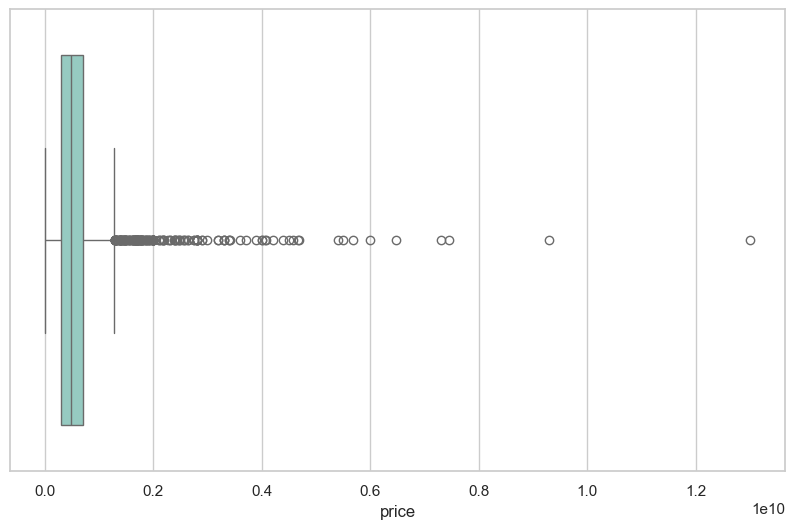

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") 

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="price",
    data=df_chotot,
    palette="Set3"  
)
plt.show()


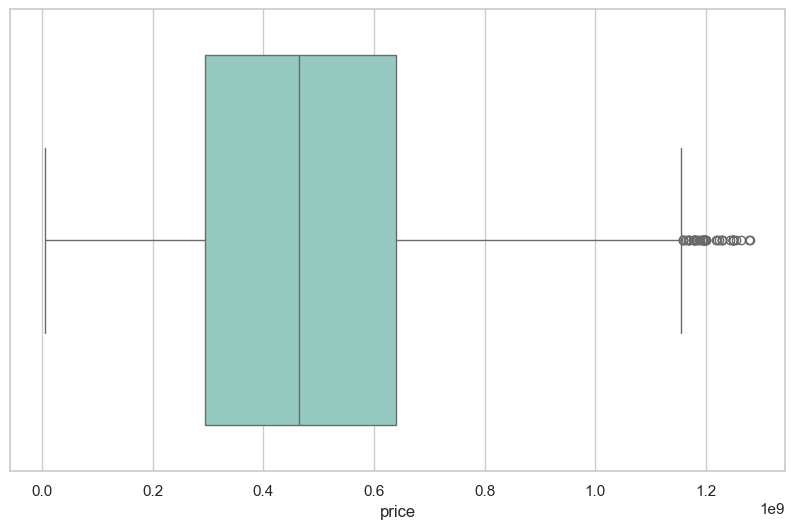

In [14]:
df_chotot = remove_outliers_iqr(df_chotot, 'price')

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="price",
    data=df_chotot,
    palette="Set3"  
)
plt.show()

3.brand

In [15]:
df_chotot["brand"].head(5)

2     Toyota
3     Toyota
4     Toyota
5        Kia
7    VinFast
Name: brand, dtype: object

In [16]:
df_chotot["brand"].isna().sum()

np.int64(0)

In [17]:
df_chotot["brand"].unique()

array(['Toyota', 'Kia', 'VinFast', 'Hyundai', 'Suzuki', 'Mazda', 'Audi',
       'Honda', 'Fiat', 'Mitsubishi', 'Chevrolet', 'Mercedes Benz',
       'Ford', 'MG', 'Daewoo', 'Nissan', 'Lexus', 'Hãng khác',
       'Dongfeng', 'Isuzu', 'BMW', 'Asia', 'SYM', 'Daihatsu',
       'Volkswagen', 'Dodge', 'MINI', 'Baic', 'Peugeot', 'Subaru',
       'Geely', 'Chery', 'Porsche', 'Smart', 'Lynk&Co', 'Gaz', 'BYD',
       'LandRover', 'Maybach', 'Jaguar', 'Citroen'], dtype=object)

4.year

In [18]:
df_chotot["age"].isna().sum()

np.int64(0)

In [19]:
df_chotot["age"] = 2025 - df_chotot["age"].astype("Int64")

In [20]:
df_chotot.head(1)

,km,origin,body,fuel,name,price,brand,age
2,None,Việt Nam,SUV / Cross over,Dầu,TOYOTA FORTUNER 2025 Giảm 50tr Tặng BH 80TR Đ,1010000000,Toyota,0


5.km

In [21]:
df_chotot["km"].head(5)

2    None
3    None
4    None
5    None
7    None
Name: km, dtype: object

In [22]:
df_chotot["km"].isna().sum()

np.int64(243)

In [23]:
df_chotot["km"].describe()

count       2216
unique       497
top       100000
freq          77
Name: km, dtype: object

In [24]:
df_chotot.loc[df_chotot["km"].isna(), "km"] = "100000"

In [25]:
df_chotot = clean_km(df_chotot, "km")

In [26]:
df_chotot.head()

,km,origin,body,fuel,name,price,brand,age
2,100000.0,Việt Nam,SUV / Cross over,Dầu,TOYOTA FORTUNER 2025 Giảm 50tr Tặng BH 80TR Đ,1010000000,Toyota,0
3,100000.0,Thái Lan,Pick-up (bán tải),Dầu,Toyota Hilux 2025 2 4L 4x2 AT xe giao ngay,675000000,Toyota,0
4,100000.0,Nước khác,Minivan (MPV),Động cơ Hybrid,INNOVA CROSS HYBRID 2025 xe giao ngay GIÁ TỐT,980000000,Toyota,0
5,100000.0,Việt Nam,Sedan,Xăng,KIA K3 2025 GIẢM 40TRIỆU TẶNG BẢO HIỂM THÂN VỎ,549000000,Kia,0
7,100000.0,Nước khác,SUV / Cross over,Điện,Limo Green Giao Xe Sớm Ưu Đãi HT Vay LS Thấp,710000000,VinFast,0


In [27]:
df_chotot = df_chotot[df_chotot["km"] > 100].reset_index(drop=True)

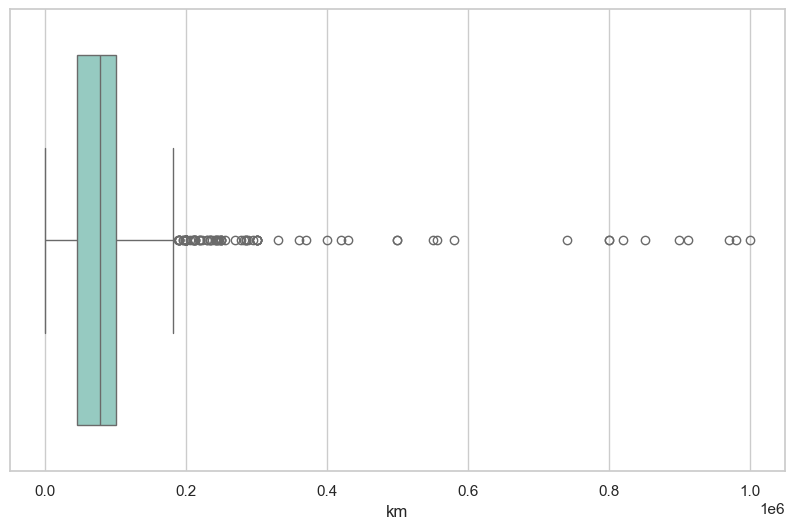

In [28]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="km",
    data=df_chotot,
    palette="Set3"  
)
plt.show()

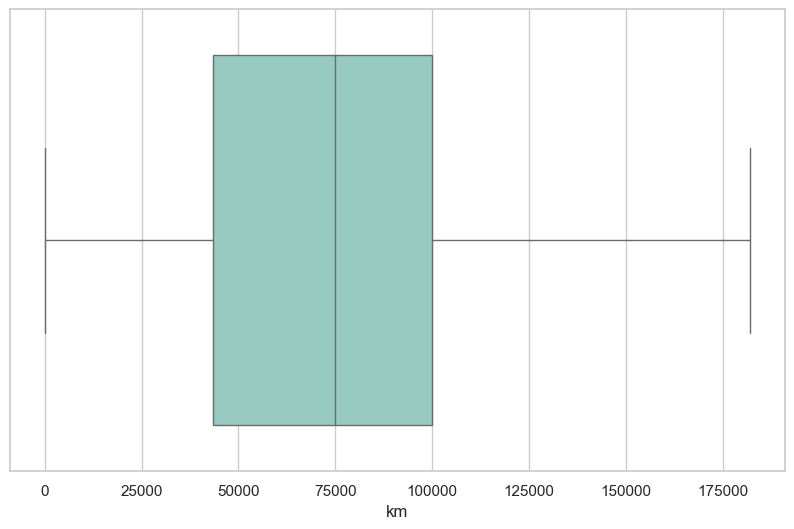

In [29]:
df_chotot = remove_outliers_iqr(df_chotot, 'km')
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="km",
    data=df_chotot,
    palette="Set3"  
)
plt.show()

6.origin

In [30]:
df_chotot["origin"].unique()

array(['Việt Nam', 'Thái Lan', 'Nước khác', 'Đức', 'Đang cập nhật',
       'Nhật Bản', 'Hàn Quốc', 'Ấn Độ', 'Mỹ', 'Trung Quốc', 'Đài Loan'],
      dtype=object)

In [31]:
df_chotot["origin"] = df_chotot["origin"].replace({
    "Việt Nam": "Trong nước"
}).apply(lambda x: "Nhập khẩu" if x not in ["Trong nước"] else x)

In [32]:
df_chotot["origin"].value_counts()

origin
Nhập khẩu     1266
Trong nước    1029
Name: count, dtype: int64

7.body

In [33]:
df_chotot["body"].isna().sum()

np.int64(256)

In [34]:
df_chotot["body"].unique()

array(['SUV / Cross over', 'Pick-up (bán tải)', 'Minivan (MPV)', 'Sedan',
       'Kiểu dáng khác', None, 'Mui trần', 'Hatchback', 'Van',
       'Coupe (2 cửa)'], dtype=object)

In [35]:
df_chotot["body"] = df_chotot["body"].fillna("Kiểu dáng khác")

In [36]:
df_chotot["body"] = df_chotot["body"].str.lower().str.strip()

8.fuel

In [37]:
df_chotot["fuel"].isna().sum()

np.int64(0)

In [38]:
df_chotot["fuel"].unique()

array(['Dầu', 'Động cơ Hybrid', 'Xăng', 'Điện'], dtype=object)

In [39]:
df_chotot["fuel"] = df_chotot["fuel"].apply(clean_fuel)

In [40]:
df_chotot["fuel"].unique()

array(['Dầu', 'Hybrid', 'Xăng', 'Điện'], dtype=object)

9.dropna

In [41]:
df_chotot = df_chotot.dropna().reset_index(drop=True)

In [42]:
df_chotot.head(5)

,km,origin,body,fuel,name,price,brand,age
0,100000.0,Trong nước,suv / cross over,Dầu,TOYOTA FORTUNER 2025 Giảm 50tr Tặng BH 80TR Đ,1010000000,Toyota,0
1,100000.0,Nhập khẩu,pick-up (bán tải),Dầu,Toyota Hilux 2025 2 4L 4x2 AT xe giao ngay,675000000,Toyota,0
2,100000.0,Nhập khẩu,minivan (mpv),Hybrid,INNOVA CROSS HYBRID 2025 xe giao ngay GIÁ TỐT,980000000,Toyota,0
3,100000.0,Trong nước,sedan,Xăng,KIA K3 2025 GIẢM 40TRIỆU TẶNG BẢO HIỂM THÂN VỎ,549000000,Kia,0
4,100000.0,Nhập khẩu,suv / cross over,Điện,Limo Green Giao Xe Sớm Ưu Đãi HT Vay LS Thấp,710000000,VinFast,0


In [43]:
df_chotot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295 entries, 0 to 2294
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   km      2295 non-null   float64
 1   origin  2295 non-null   object 
 2   body    2295 non-null   object 
 3   fuel    2295 non-null   object 
 4   name    2295 non-null   object 
 5   price   2295 non-null   Int64  
 6   brand   2295 non-null   object 
 7   age     2295 non-null   Int64  
dtypes: Int64(2), float64(1), object(5)
memory usage: 148.0+ KB


10.updata

In [44]:
upload_to_bigquery(df_chotot, table_id=table_id, if_exists="append" )

✅ Uploaded 2295 rows to khangtestdbt.xecupredict.data_cleaned


In [45]:
#end